<h1 align="center">Time Series Analysis - Forecasting Models</h1>
<h2 align="center">Descriptive Statistics and Tests</h2>
<h3 align="center">Rositsa Chankova</h3> 

# Descriptive Statistics and Tests
**Forecasting models like ARMA, ARIMA, Seasonal ARIMA and others, addresse a different type of time series. For this reason, in order to select an appropriate model a preliminary knowledge of the data is required.**

**Bellow a way to determine if a time series is <em>stationary</em>, if it's <em>independent</em>, and if two series demonstrate <em>correlation</em> and/or <em>causality</em> is shown.**

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load a seasonal dataset
df1 = pd.read_csv('passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('births.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [2]:
from statsmodels.tsa.stattools import ccovf,ccf 

In [3]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [4]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# Tests for Stationarity

**A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where one takes the observations, the results should be the same. A times series that shows seasonality is <em>NOT</em> stationary.**

**A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity.**

**The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests.**

## Augmented Dickey-Fuller Test

**To determine whether a series is stationary the Augmented_Dickey-Fuller_test is used. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics. The focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.**

**A dataset that is known as being  <em>NOT</em> stationary will be used.**

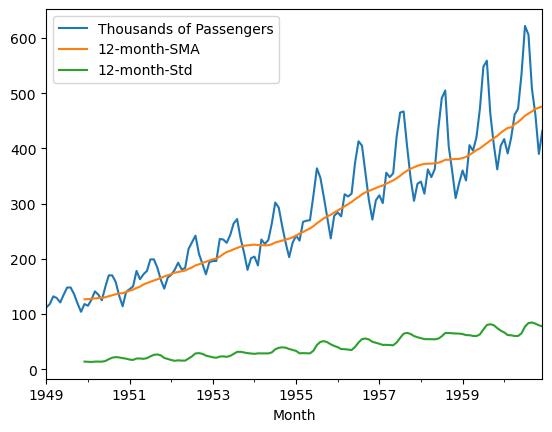

In [5]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();

**Not only is this dataset seasonal with a clear upward trend, the standard deviation increases over time as well.**

In [6]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df1['Thousands of Passengers'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(0.8153688792060472,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

**To find out what these values represent run <tt>help(adfuller)</tt>. Then add new labels:**

In [7]:
print('Augmented Dickey-Fuller Test on Airline Data')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Airline Data
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64


**A very high p-value at 0.99, provides weak evidence against the null hypothesis, and failure to reject the null hypothesis leads to a decission the dataset is not stationary.**

### Apply the ADF test to stationary data with the Daily Total Female Births dataset.

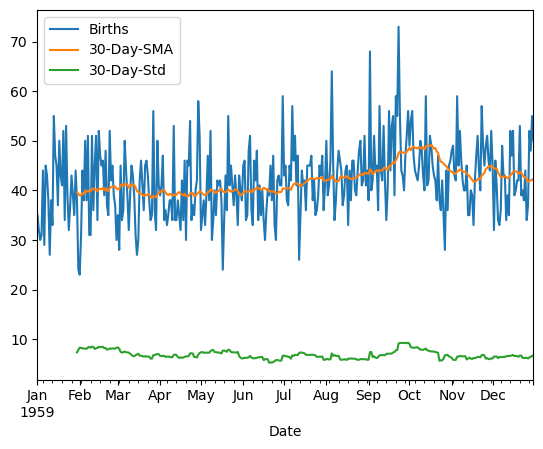

In [8]:
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()

df2[['Births','30-Day-SMA','30-Day-Std']].plot();

In [9]:
print('Augmented Dickey-Fuller Test on Daily Female Births')
dftest = adfuller(df2['Births'],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Daily Female Births
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
dtype: float64


**In this case the p-value is very low at 0.000052, so the null hypothesis must be rejected. This dataset appears to have no unit root, and is stationary.**

### Function for running the augmented Dickey-Fuller test

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Granger Causality Tests

**The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time.**

**This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. It may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case one series "Granger-causes" another.**

**In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br> In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.**

**The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries.**

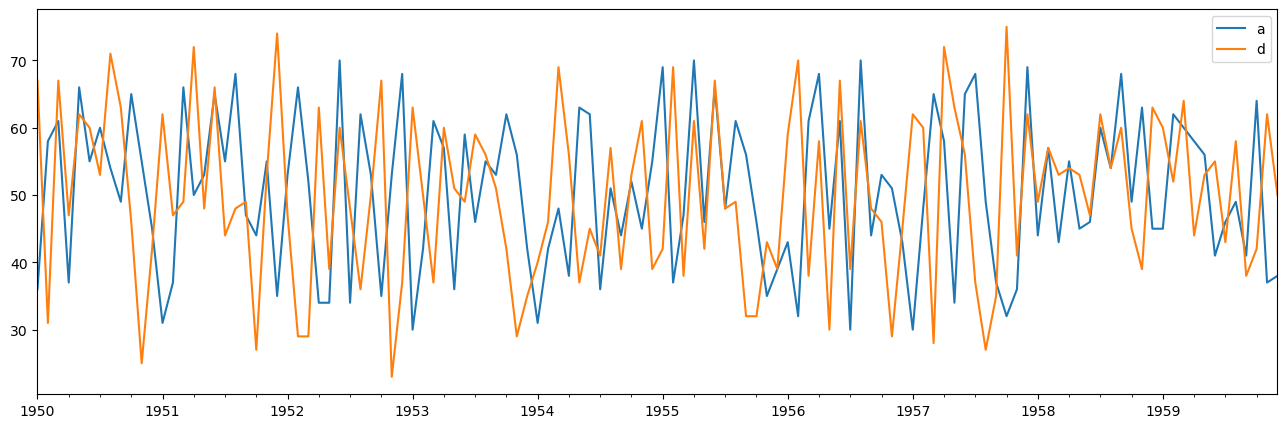

In [11]:
#In samples.csv file, where columns 'a' and 'd' are stationary datasets.
df3 = pd.read_csv('samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'
df3[['a','d']].plot(figsize=(16,5));

**It's hard to tell from this overlay but <tt>df['d']</tt> almost perfectly predicts the behavior of <tt>df['a']</tt>. To see this more clearly, <tt>df['d']</tt> is shifted two periods forward.**

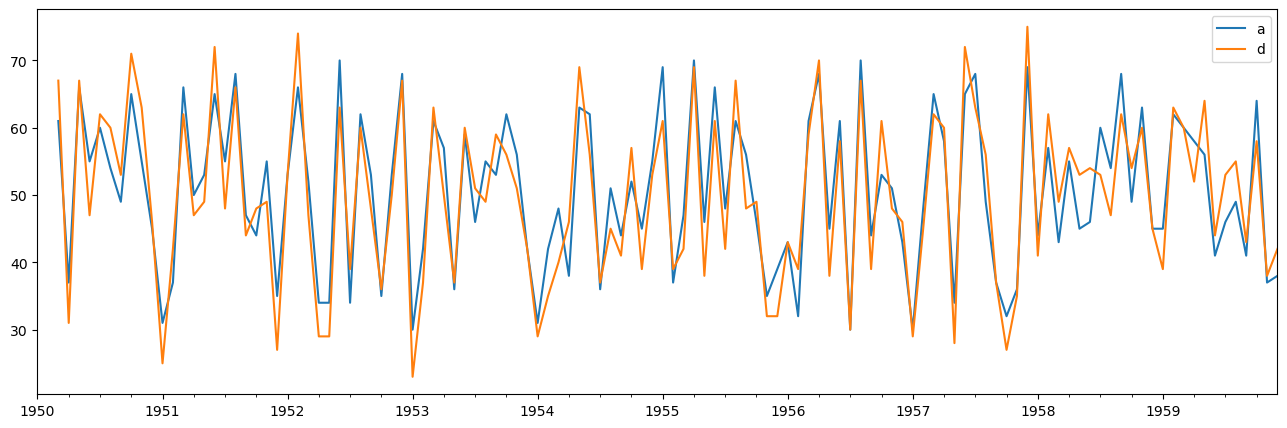

In [12]:
df3['a'].iloc[2:].plot(figsize=(16,5),legend=True);
df3['d'].shift(2).plot(legend=True);

### Run the test
**The function takes in a 2D array [y,x] and a maximum number of lags to test on x.  
y is column 'a', x is column 'd', maxlags is set 3.**

In [13]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


**Essentially looking for extremely low p-values, which is seen at lag 2. By comparison the two datasets that are not at all similar, 'b' and 'd'.**

In [14]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['b','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


That's it!

# Evaluating forecast accuracy
Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

**A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.**

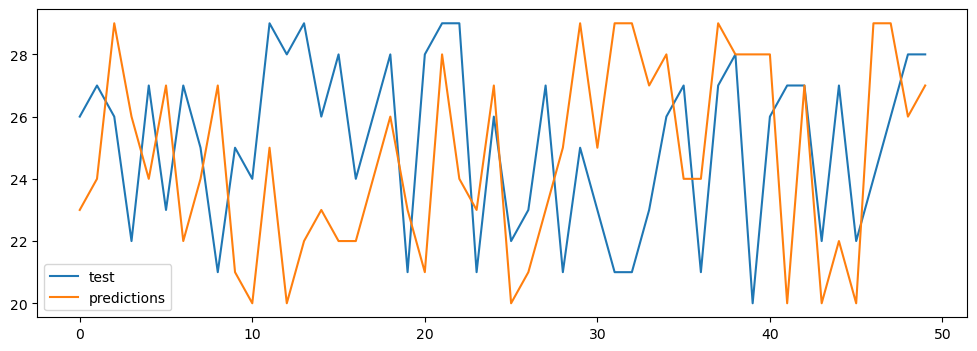

In [15]:
import numpy as np
import pandas as pd
%matplotlib inline
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])
df.plot(figsize=(12,4));

In [16]:
MSE = mse(df['test'],df['predictions'])
RMSE = rmse(df['test'],df['predictions'])
MAE = meanabs(df['test'],df['predictions'])

print(f'Model  MSE: {MSE:.3f}')
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model  MAE: {MAE:.3f}')

Model  MSE: 17.020
Model RMSE: 4.126
Model  MAE: 3.540


### AIC / BIC

**More sophisticated tests include the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>Akaike information criterion</strong></a> (AIC) and the <a href='https://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Bayesian information criterion</strong></a> (BIC).**

**The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

## Exposing Seasonality with Month and Quarter Plots
**Statsmodels has two plotting functions that group data by month and by quarter. If the data appears as months,  <em>resampling</em> with an aggregate function before running a quarter plot should be empployed.**

In [18]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


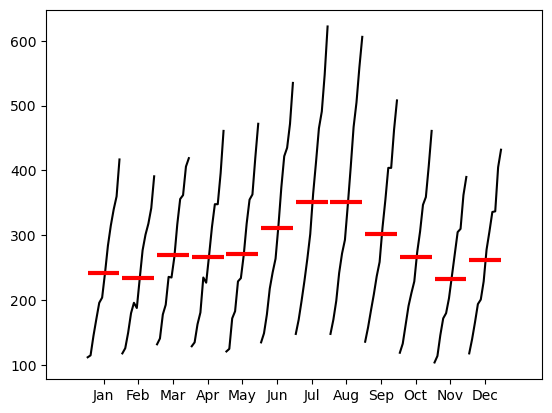

In [19]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

# Note: add a semicolon to prevent two plots being displayed in jupyter
month_plot(df['Thousands of Passengers']);

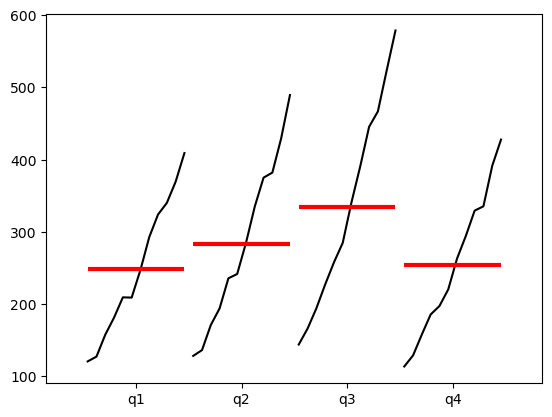

In [20]:
dfq = df['Thousands of Passengers'].resample(rule='Q').mean()

quarter_plot(dfq);

Let's compare this to our nonseasonal <tt>macrodata.csv</tt> dataset:

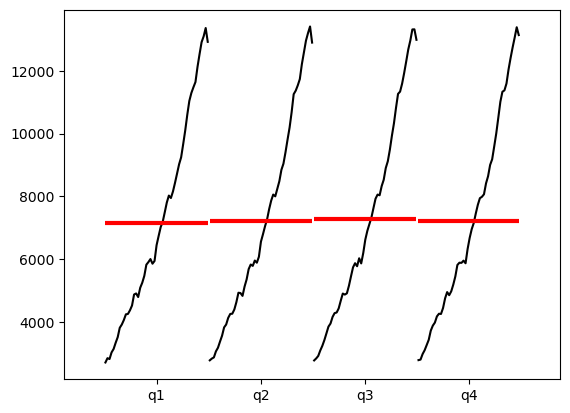

In [21]:
df3 = pd.read_csv('macrodata.csv',index_col=0,parse_dates=True)
quarter_plot(df3['realgdp']);